In [1]:
#最简单版本的cycle-gan的实现
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
try:
    from kaggle_datasets import KaggleDatasets
except:
    pass
tf.__version__

'2.6.4'

In [2]:
#加载数据集
GCS_PATH = "../input/horse2zebra"
monet_path = GCS_PATH+"/horse2zebra/trainB/*"
photo_path =  GCS_PATH+"/horse2zebra/trainA/*"


monet_path = tf.io.gfile.glob(monet_path)
photo_path = tf.io.gfile.glob(photo_path)

monet_path[0],photo_path[0]

('../input/horse2zebra/horse2zebra/trainB/n02391049_275.jpg',
 '../input/horse2zebra/horse2zebra/trainA/n02381460_4625.jpg')

In [3]:
len(monet_path),len(photo_path)

(1334, 1067)

In [4]:
#读取图片
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img,channels=3)
    
    return img

2022-10-16 18:27:50.834213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 18:27:50.926062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 18:27:50.926794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 18:27:50.937997: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

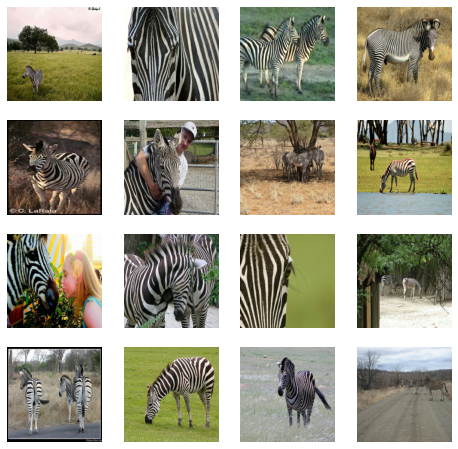

In [5]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    img = load_img(monet_path[i])
    plt.axis('off')
    plt.imshow(img)

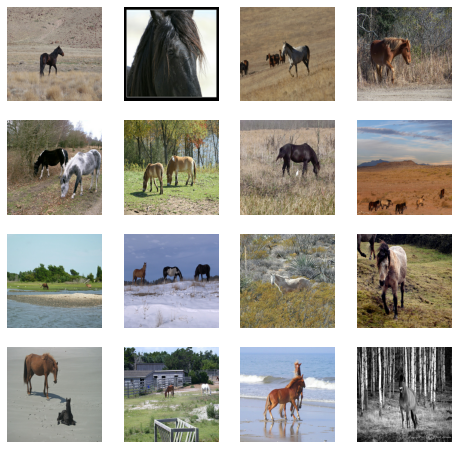

In [6]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    img = load_img(photo_path[i])
    plt.axis('off')
    plt.imshow(img)

In [7]:
def load_data(path):
    img = load_img(path)
    img = tf.image.resize(img,(256,256))
    img = tf.cast(img,tf.float32)
    img = img/127.5 -1
    return img
x_ds =  tf.data.Dataset.from_tensor_slices((photo_path))
y_ds =  tf.data.Dataset.from_tensor_slices((monet_path))

x_ds = x_ds.map(load_data)
y_ds = y_ds.map(load_data)

x_ds = x_ds.shuffle(1024).prefetch(1024).batch(1)
y_ds = y_ds.shuffle(1024).prefetch(1024).batch(1)
x_ds,y_ds

(<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>,
 <BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>)

In [8]:
#下面是网络定义部分

def down_sample(filters,size):
    layer = tf.keras.Sequential()
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0,stddev=0.02)
    layer.add(tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    layer.add(tf.keras.layers.LeakyReLU())
    return layer

def up_sample(filters,size):
    layer = tf.keras.Sequential()
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0,stddev=0.02)
    layer.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    layer.add(tf.keras.layers.Dropout(0.5))
    layer.add(tf.keras.layers.LeakyReLU())
    return layer

In [9]:
def Generator():
    inputs = tf.keras.layers.Input(shape=(256,256,3))


    down_stack = [
        down_sample(64,4),
        down_sample(128,4),
        down_sample(256,4),
        down_sample(512,4),
        down_sample(512,4),
        down_sample(512,4),
        down_sample(512,4),
        down_sample(512,4),
    ]
    
    up_stack = [
        up_sample(512,4),
        up_sample(512,4),
        up_sample(512,4),
        up_sample(512,4),
        
        up_sample(256,4),
        up_sample(128,4),
        up_sample(64,4),
    ]
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.concatenate([x,skip])
    x = tf.keras.layers.Conv2DTranspose(3,3,strides=2,padding='same',activation='tanh')(x)
    outputs = x
    model = tf.keras.Model(inputs = inputs,outputs = outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5))
    return model
gen = Generator()

In [10]:
from tensorflow.keras.utils import plot_model


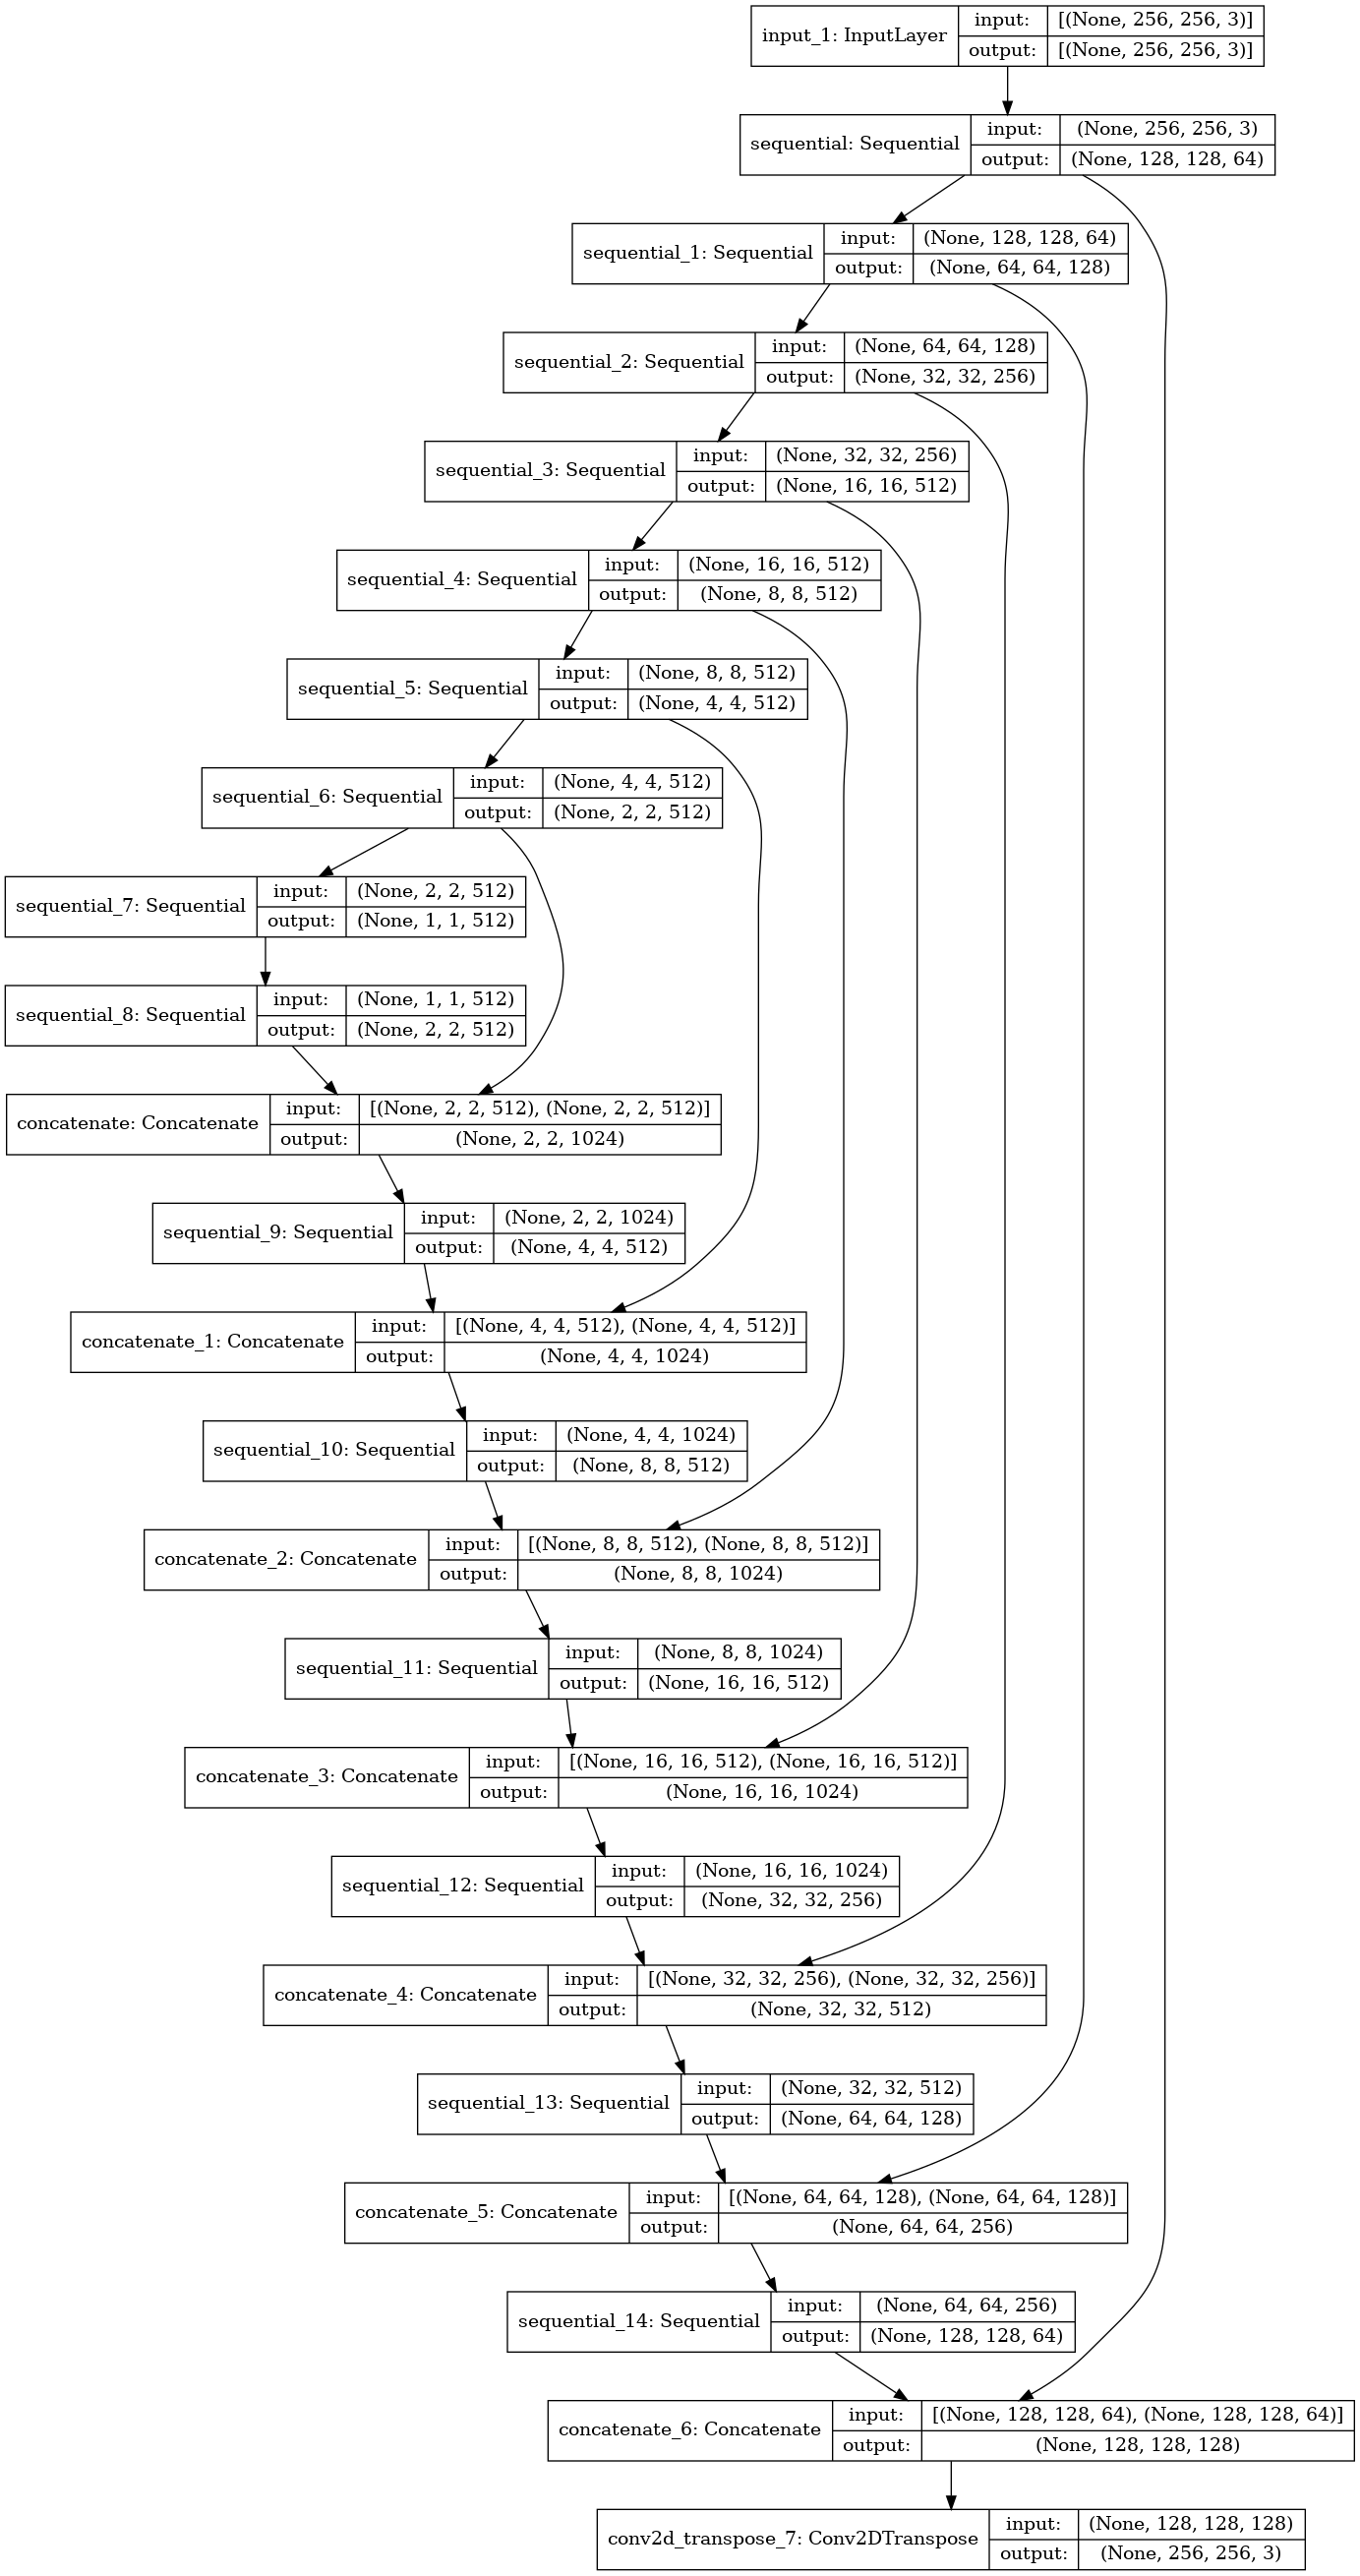

In [11]:
plot_model(gen,show_shapes=True)

In [12]:
def dis():
    initializer = tf.random_normal_initializer(0,0.02)
    
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.,stddev=0.02)
    
    inputs = tf.keras.layers.Input(shape=(256,256,3))
    
    x = inputs
    
    x = down_sample(64,4)(x)
    x = down_sample(128,4)(x)
    x = down_sample(256,4)(x)
   
    
    x= tf.keras.layers.Conv2D(521,3,)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x= tf.keras.layers.Conv2D(1,3,padding='same')(x)
   
    outputs = x
    
    model = tf.keras.Model(inputs=inputs,outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5))
    return model

dis().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 128, 128, 64)      3200      
_________________________________________________________________
sequential_16 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_17 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 521)       1200905   
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 30, 30, 521)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 1)         4690

In [13]:
#判别器损失
def dis_loss(real,fake):
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake),fake)
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real),real)
    
    total_loss = fake_loss+real_loss
    return tf.reduce_mean(total_loss*0.5)
#生成器损失
def gen_loss(fake):
    
    gen_loos = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake),fake)
    
    return tf.reduce_mean(gen_loos)
#循环一致性损失
def cycle_loss(real,fake):
    loss = tf.abs(real-fake)
    return tf.reduce_mean(loss)*10
def ident_loss(real,fake):
    loss = tf.abs(real-fake)
    return tf.reduce_mean(loss)*10*0.5

In [14]:


f_gen = Generator()
y_gen = Generator()
f_dis = dis()
y_dis = dis()


In [15]:
show_ds = x_ds.take(8)
test_ds = []
for d in show_ds:
    test_ds.append(d)
#print(test_ds)

2022-10-16 18:28:00.766791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2022-10-16 18:28:05.838859: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


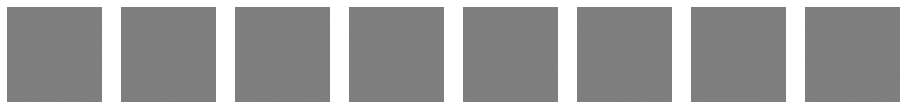

In [16]:

def show_img():
    plt.figure(figsize=(16,32))
    
    k=0
    for d in test_ds:
        k+=1
        plt.subplot(1,8,k)
        y = y_gen.predict(d[:1])
        y = tf.squeeze(y)
        y = (y+1)*127.5
        y = tf.cast(y,tf.int32)
        #y = np.array(y)
        plt.imshow(y)
        plt.axis('off')
        #print(y)
    plt.show()
show_img()

In [17]:
@tf.function()
def train_step(x,y):
    with tf.GradientTape(persistent=True) as tape:
        y_fake = y_gen(x,training=True)
        cycle_x = f_gen(y_fake,training=True)
        x_fake = f_gen(y,training=True)
        cycle_y = y_gen(x_fake,training=True)
    
        y_real_out = y_dis(y,training=True)
        y_fake_out = y_dis(y_fake,training=True)
        
        f_real_out = f_dis(x,training=True)
        f_fake_out = f_dis(x_fake,training=True)
        
        y_dis_loss = dis_loss(y_real_out,y_fake_out)
        f_dis_loss = dis_loss(f_real_out,f_fake_out)
        
        same_x = f_gen(x,training=True)
        same_y = y_gen(y,training=True)
        total_cycle_loss = cycle_loss(x,cycle_x)+cycle_loss(y,cycle_y)
        ident_loss_y = ident_loss(x,same_x)
        ident_loss_f = ident_loss(y,same_y)
        y_gen_loss = gen_loss(y_fake_out)+total_cycle_loss+ident_loss_y
        f_gen_loss = gen_loss(f_fake_out)+total_cycle_loss+ident_loss_f
        #print(y_fake)
    y_gen_grad = tape.gradient(y_gen_loss,y_gen.trainable_variables)
    f_gen_grad = tape.gradient(f_gen_loss,f_gen.trainable_variables)
    y_dis_grad = tape.gradient(y_dis_loss,y_dis.trainable_variables)
    f_dis_grad =tape.gradient(f_dis_loss,f_dis.trainable_variables)
    
    y_gen.optimizer.apply_gradients(zip(y_gen_grad,y_gen.trainable_variables))
    f_gen.optimizer.apply_gradients(zip(f_gen_grad,f_gen.trainable_variables))
    
    y_dis.optimizer.apply_gradients(zip(y_dis_grad,y_dis.trainable_variables))
    f_dis.optimizer.apply_gradients(zip(f_dis_grad,f_dis.trainable_variables))

epoch:0:1066


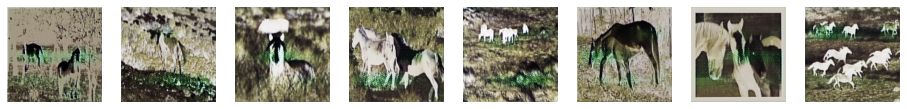

epoch:1:1066
epoch:2:1066
epoch:3:1066
epoch:4:1066
epoch:5:1066
epoch:6:1066
epoch:7:1066
epoch:8:1066
epoch:9:1066
epoch:10:1066


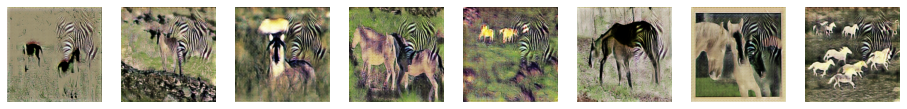

epoch:11:1066
epoch:12:1066
epoch:13:1066
epoch:14:1066
epoch:15:1066
epoch:16:1066
epoch:17:1066
epoch:18:1066
epoch:19:1066
epoch:20:1066


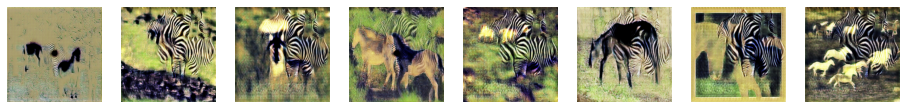

epoch:21:1066
epoch:22:1066
epoch:23:1066
epoch:24:1066
epoch:25:1066
epoch:26:1066
epoch:27:1066
epoch:28:1066
epoch:29:1066
epoch:30:1066


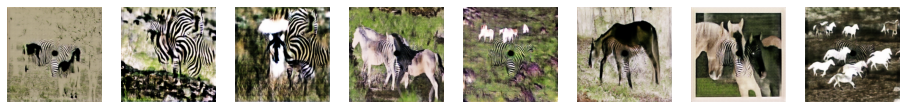

epoch:31:1066
epoch:32:1066
epoch:33:1066
epoch:34:1066
epoch:35:1066
epoch:36:1066
epoch:37:1066
epoch:38:1066
epoch:39:1066
epoch:40:1066


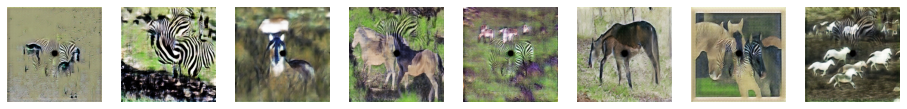

epoch:41:1066
epoch:42:1066
epoch:43:1066
epoch:44:1066
epoch:45:1066
epoch:46:1066
epoch:47:1066
epoch:48:1066
epoch:49:1066
epoch:50:1066


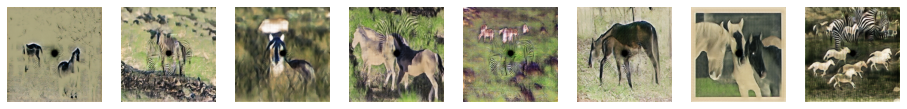

epoch:51:1066
epoch:52:1066
epoch:53:1066
epoch:54:1066
epoch:55:1066
epoch:56:1066
epoch:57:1066
epoch:58:1066
epoch:59:1066
epoch:60:1066


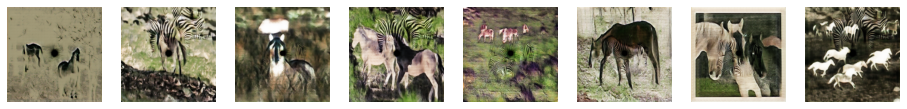

epoch:61:1066
epoch:62:1066
epoch:63:1066
epoch:64:1066
epoch:65:1066
epoch:66:1066
epoch:67:1066
epoch:68:1066
epoch:69:1066
epoch:70:1066


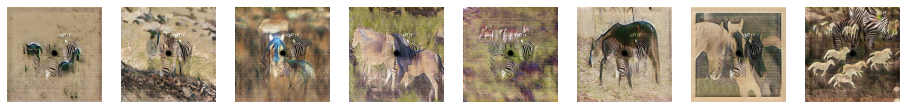

epoch:71:1066
epoch:72:1066
epoch:73:1066
epoch:74:1066
epoch:75:1066
epoch:76:1066
epoch:77:1066
epoch:78:1066
epoch:79:1066
epoch:80:1066


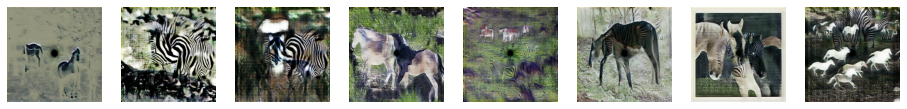

epoch:81:1066
epoch:82:1066
epoch:83:1066
epoch:84:1066
epoch:85:1066
epoch:86:1066
epoch:87:1066
epoch:88:1066
epoch:89:1066
epoch:90:1066


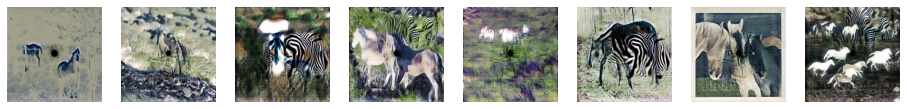

epoch:91:1066
epoch:92:1066
epoch:93:1066
epoch:94:1066
epoch:95:1066
epoch:96:1066
epoch:97:1066
epoch:98:1066
epoch:99:1066


In [18]:

def train(epochs):
    for epoch in range(0,epochs):
        i=0
        
       
        for x,y in zip(x_ds,y_ds):
            print("\r",end="")
            print("epoch:{}:{}".format(epoch,i),end="")
            train_step(x,y)
            i+=1
            #break
        print("")
        if epoch%10==0:
            show_img()
            y_gen.save_weights("y_gen.h5")
            f_gen.save_weights("f_gen.h5")
            
            y_dis.save_weights("y_dis.h5")
            f_dis.save_weights("f_dis.h5")
        #print(i)
train(100)